In [16]:
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from dotenv import load_dotenv, find_dotenv

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Without LLM

In [5]:
class QuadState(TypedDict):
    a: int
    b: int
    c: int
    equation: str
    discriminant: float
    result: str

In [6]:
def show_equation(state: QuadState):
    equation = f"{state['a']}x2{state['b']}x{state['c']}"
    return {'equation': equation}


def calculate_discriminant(state: QuadState):
    discriminant = state['b']**2 - (4*state['a']*state['c'])
    return {'discriminant': discriminant}

In [10]:
def real_roots(state: QuadState):
    root1 = (-state['b'] + state['discriminant']**0.5) / (2*state['a'])
    root2 = (-state['b'] - state['discriminant']**0.5) / (2*state['a'])
    result = f"Roots are: {root1} and {root2}"
    return {'result': result}


def repeated_roots(state: QuadState):
    root = (-state['b']) / (2*state['a'])
    result = f"Only repeated root is: {root}"

    return {"result": result}

def no_real_roots(state: QuadState):
    result = "No real roots present"

    return {"result": result}


In [12]:
def check_condition(state: QuadState) -> Literal["real_roots", "repeated_roots", "no_real_roots"]:
    if state["discriminant"] > 0:
        return "real_roots"
    elif state["discriminant"] == 0:
        return "repeated_roots"
    else:
        return "no_real_roots"

In [13]:
graph = StateGraph(state_schema=QuadState)
graph.add_node('show_equation', show_equation)
graph.add_node('calculate_discriminant', calculate_discriminant)
graph.add_node('real_roots', real_roots)
graph.add_node('repeated_roots', repeated_roots)
graph.add_node('no_real_roots', no_real_roots)

graph.add_edge(START, 'show_equation')
graph.add_edge('show_equation', 'calculate_discriminant')
graph.add_conditional_edges(
    'calculate_discriminant',
    check_condition
)
graph.add_edge('real_roots', END)
graph.add_edge('repeated_roots', END)
graph.add_edge('no_real_roots', END)

graph = graph.compile()

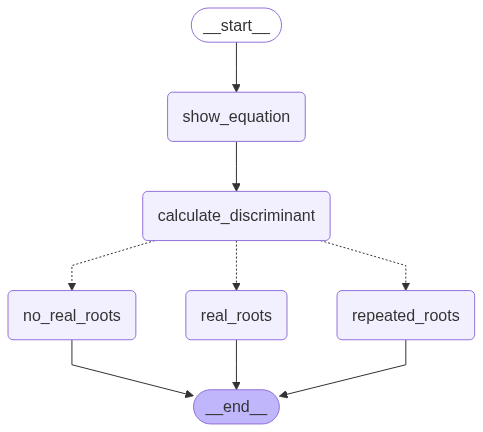

In [14]:
graph

In [15]:
graph.invoke(
    {
        'a': 4,
        'b': -5,
        'c': -4
    }
)

{'a': 4,
 'b': -5,
 'c': -4,
 'equation': '4x2-5x-4',
 'discriminant': 89,
 'result': 'Roots are: 1.8042476415070754 and -0.5542476415070754'}

## With LLM

In [42]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")

In [43]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [44]:
structured_model = llm.with_structured_output(SentimentSchema)
structured_model2 = llm.with_structured_output(DiagnosisSchema)


In [45]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [50]:
def find_sentiment(state: ReviewState):
    prompt = f"For the following review, find out the sentiment \n\n Review: {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}


def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagonsis"]:
    if state['sentiment'] == "positive":
        return "positive_response"
    else:
        return "run_diagonsis"
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = llm.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = llm.invoke(prompt).content

    return {'response': response}

In [51]:
graph = StateGraph(state_schema=ReviewState)
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagonsis', run_diagnosis)
graph.add_node('negative_response', negative_response)
graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges(
    'find_sentiment',
    check_sentiment
)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagonsis', 'negative_response')
graph.add_edge('negative_response', END)

graph = graph.compile()

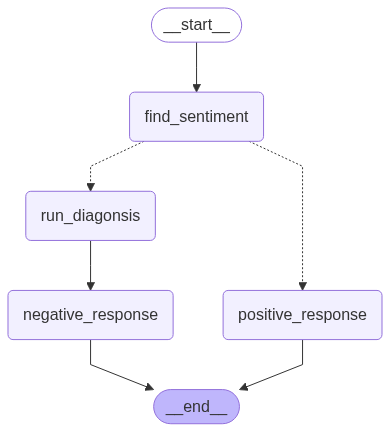

In [52]:
graph

In [53]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
graph.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: We're Here to Help with Your Bug Issue\n\nHi [User's Name],\n\nI hope this message finds you well. I want to sincerely apologize for the frustration you’re experiencing with the bug issue. I understand how important this is to you, and I appreciate your patience as we work to resolve it.\n\nTo assist you better, could you please provide a bit more detail about the issue? Specifically, any error messages you’re seeing or the steps you took before the bug occurred would be incredibly helpful. This information will allow us to diagnose the problem more effectively and find a solution as quickly as possible.\n\nThank you for